In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

# Data

In [2]:
df_freq = pd.read_csv("./data/insurance/freMTPL2freq.csv")
df_freq["IDpol"] = df_freq["IDpol"].astype(int)
df_freq.set_index("IDpol", inplace=True)

df_sev = pd.read_csv("./data/insurance/freMTPL2sev.csv")
df_sev["IDpol"] = df_sev["IDpol"].astype(int)
# Sum claim amounts for each unique ID
df_sev = df_sev.groupby("IDpol").sum()

df = df_freq.join(df_sev, how="left")
# Any IDs with no claims appear as NaN, so replace with 0
df["ClaimAmount"].fillna(0, inplace=True)

# Linear Model Coefficient Interpretation

Model is $ Exposure \sim \mathcal{N}(\alpha + \beta_1 Region_1 + \ldots + \beta_{n-1} Region_{n-1}, \sigma^2) $ where $ n $ is the number of regions. We have one fewer predictors because one becomes the base level.

In [134]:
regions = df["Region"].unique()
regions = sorted(regions)
regions

['R11',
 'R21',
 'R22',
 'R23',
 'R24',
 'R25',
 'R26',
 'R31',
 'R41',
 'R42',
 'R43',
 'R52',
 'R53',
 'R54',
 'R72',
 'R73',
 'R74',
 'R82',
 'R83',
 'R91',
 'R93',
 'R94']

In [135]:
len(regions)

22

Here, R11 is the base region, and $ n = 22 $

In [136]:
y, X = dmatrices("Exposure ~ Region", data=df)

model = sm.OLS(y, X)
results = model.fit()

In [137]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Exposure   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2241.
Date:                Sun, 25 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:13:17   Log-Likelihood:            -2.5493e+05
No. Observations:              678013   AIC:                         5.099e+05
Df Residuals:                  677991   BIC:                         5.101e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4328      0.001    324.468      0.000       0.430       0.435
Region[T.R21]    -0.0344      0.007     -5.250      0.000      -0.047      -0.022
Region[T.R22]     0.0143      0.004      3.435      0.001       0.006       0.022
Region[T.R23]    -0.0711      0.004    -17.817      0.000      -0.079      -0.063
Region[T.R24]     0.2067      0.002    129.372      0.000       0.204       0.210
Region[T.R25]     0.1784      0.004     49.128      0.000       0.171       0.185
Region[T.R26]     0.0461      0.004     12.500      0.000       0.039       0.053
Region[T.R31]    -0.0114      0.003     -4.547      0.000      -0.016      -0.007
Region[T.R41]     0.1918      0.003     56.946      0.000       0.185       0.198
Region[T.R42]     0.1168      0.008     15.300      0.000       0.102       0.132
Region[T.R43]    -0.0075      0.010     -0.767      0.443      -0.027       0.012
Region[T.R52]     0.1332      0.002     59.652      0.000       0.129       0.138
Region[T.R53]     0.2260      0.002    103.953      0.000       0.222       0.230
Region[T.R54]     0.1533      0.003     53.204      0.000       0.148       0.159
Region[T.R72]     0.0243      0.002     10.143      0.000       0.020       0.029
Region[T.R73]    -0.0233      0.003     -7.754      0.000      -0.029      -0.017
Region[T.R74]     0.0918      0.005     17.052      0.000       0.081       0.102
Region[T.R82]     0.1022      0.002     56.742      0.000       0.099       0.106
Region[T.R83]     0.0065      0.005      1.296      0.195      -0.003       0.016
Region[T.R91]    -0.0213      0.002     -9.288      0.000      -0.026      -0.017
Region[T.R93]     0.0184      0.002     10.059      0.000       0.015       0.022
Region[T.R94]    -0.0418      0.005     -7.725      0.000      -0.052      -0.031
==============================================================================
Omnibus:                 14042346.469   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51385.937
Skew:                           0.030   Prob(JB):                         0.00
Kurtosis:                       1.653   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So, the interpretation of these coefficients is that the intercept represents the mean exposure of the base category, in this case region R11:

In [138]:
base_cat_mean = df.loc[df["Region"] == "R11", "Exposure"].mean()
base_cat_mean

0.432844377562832

And the other coefficients represent the *difference* in the mean for that category compared to the base category:

In [139]:
# Mean for region R21
r21_cat_mean = df.loc[df["Region"] == "R21", "Exposure"].mean()
r21_cat_mean

0.39849025416225786

In [140]:
# Difference in mean is the coefficient
r21_cat_mean - base_cat_mean

-0.034354123400574144

# Generalized Linear Model Coefficient Interpretation

Now, for sake of illustration our model is $ Exposure \sim \mathcal{N}(\mu, \sigma^2) $ where $ \log(\mu) = \alpha + \beta_1 Region_1 + \ldots + \beta_{n-1} Region_{n-1} $. This effectively a generalized linear model with a log link and normally distributed outcomes.

In [141]:
# Using the same set of predictor variables
model = sm.GLM(y, X, family=sm.families.Gaussian(link=sm.families.links.Log()))
results = model.fit()

In [142]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Exposure   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677991
Model Family:                Gaussian   Df Model:                           21
Link Function:                    Log   Scale:                         0.12420
Method:                          IRLS   Log-Likelihood:            -2.5493e+05
Date:                Sun, 25 Jun 2023   Deviance:                       84206.
Time:                        15:13:20   Pearson chi2:                 8.42e+04
No. Iterations:                     7   Pseudo R-squ. (CS):            0.06706
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.8374      0.003   -271.702      0.000      -0.843      -0.831
Region[T.R21]    -0.0827      0.016     -5.052      0.000      -0.115      -0.051
Region[T.R22]     0.0325      0.009      3.479      0.001       0.014       0.051
Region[T.R23]    -0.1794      0.011    -16.548      0.000      -0.201      -0.158
Region[T.R24]     0.3904      0.003    115.679      0.000       0.384       0.397
Region[T.R25]     0.3451      0.006     54.546      0.000       0.333       0.357
Region[T.R26]     0.1013      0.008     12.955      0.000       0.086       0.117
Region[T.R31]    -0.0268      0.006     -4.520      0.000      -0.038      -0.015
Region[T.R41]     0.3668      0.006     62.894      0.000       0.355       0.378
Region[T.R42]     0.2388      0.014     17.041      0.000       0.211       0.266
Region[T.R43]    -0.0175      0.023     -0.761      0.447      -0.062       0.028
Region[T.R52]     0.2683      0.004     60.745      0.000       0.260       0.277
Region[T.R53]     0.4202      0.004    104.101      0.000       0.412       0.428
Region[T.R54]     0.3032      0.005     56.807      0.000       0.293       0.314
Region[T.R72]     0.0546      0.005     10.241      0.000       0.044       0.065
Region[T.R73]    -0.0553      0.007     -7.620      0.000      -0.070      -0.041
Region[T.R74]     0.1923      0.010     18.480      0.000       0.172       0.213
Region[T.R82]     0.2120      0.004     55.450      0.000       0.205       0.219
Region[T.R83]     0.0149      0.011      1.304      0.192      -0.008       0.037
Region[T.R91]    -0.0504      0.005     -9.207      0.000      -0.061      -0.040
Region[T.R93]     0.0416      0.004     10.040      0.000       0.034       0.050
Region[T.R94]    -0.1016      0.014     -7.381      0.000      -0.129      -0.075
=================================================================================
"""

Now, these coefficients are all in log space, so we need to consider their exponentiated values to interpret them. First, the intercept still represents the mean value of the base category:

In [143]:
base_cat_mean

0.432844377562832

In [144]:
# Exponential of intercept
np.exp(-0.8374)

0.43283443123701093

However, the coefficients of the other variables represents a multiplicative change over the base category mean. Taking the exponentiated coefficient of the R21 region variable:

In [145]:
np.exp(-0.0827)

0.9206272939842343

The interpretation of this is that the mean of exposures in region R21 is 0.92 times the mean of the base category exposures:

In [146]:
r21_cat_mean

0.39849025416225786

In [147]:
np.exp(-0.0827) * base_cat_mean

0.39848834803196026

So, by operating under a log link we move to coefficients representing multiplication and not addition.

# Varying Intercepts Alternative

In [148]:
region, regions = df["Region"].factorize()
obs = df.index

with pm.Model(coords={"regions": regions, "obs": obs}) as model:
    sigma = pm.HalfNormal("sigma", 25)
    alpha = pm.Normal("alpha", 0, 10, dims="regions")

    exposure = pm.Normal(
        "exposure", alpha[region], sigma, observed=df["Exposure"].values, dims="obs"
    )

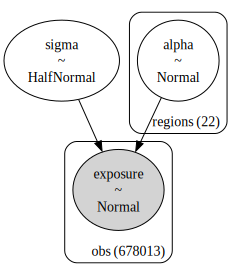

In [149]:
pm.model_to_graphviz(model)

In [150]:
with model:
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 177 seconds.


In [131]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[R82],0.535,0.001,0.533,0.537,0.0,0.0,11135.0,2476.0,1.0
alpha[R22],0.447,0.004,0.440,0.454,0.0,0.0,9315.0,2417.0,1.0
alpha[R72],0.457,0.002,0.453,0.461,0.0,0.0,9716.0,2853.0,1.0
alpha[R31],0.421,0.002,0.417,0.425,0.0,0.0,11186.0,2783.0,1.0
alpha[R91],0.412,0.002,0.408,0.415,0.0,0.0,10051.0,2722.0,1.0
alpha[R52],0.566,0.002,0.563,0.569,0.0,0.0,11283.0,3048.0,1.0
alpha[R93],0.451,0.001,0.449,0.454,0.0,0.0,10658.0,3085.0,1.0
alpha[R11],0.433,0.001,0.430,0.435,0.0,0.0,11291.0,2660.0,1.0
alpha[R24],0.640,0.001,0.638,0.641,0.0,0.0,8434.0,2644.0,1.0
alpha[R94],0.391,0.005,0.381,0.401,0.0,0.0,11746.0,3132.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

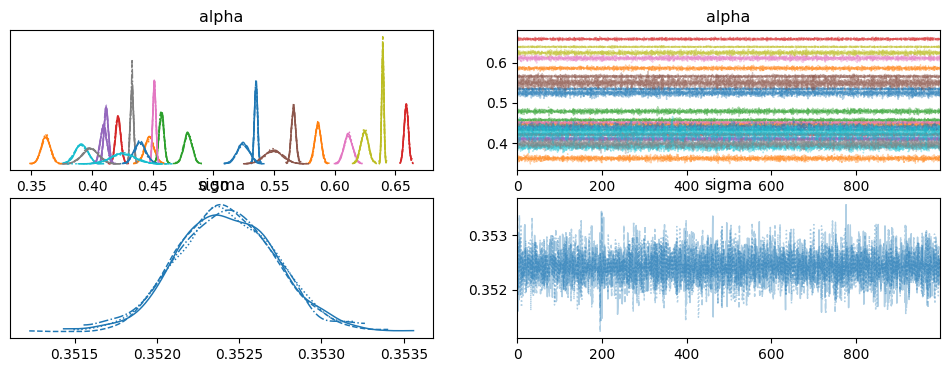

In [151]:
az.plot_trace(idata)

<Axes: >

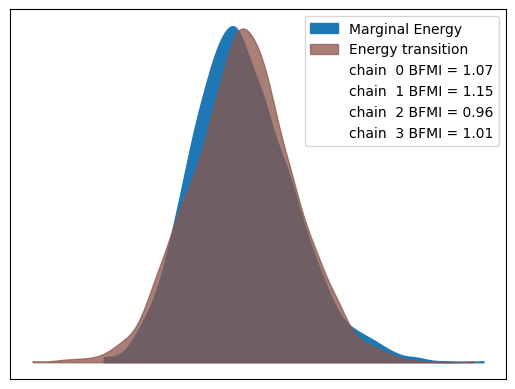

In [152]:
az.plot_energy(idata)

In [206]:
stacked = az.extract(idata)
# Mean values of alpha for each region
stacked.mean(dim="sample").alpha.to_dataframe().sort_index()

,alpha
regions,
R11,0.432845
R21,0.398569
R22,0.447167
R23,0.361863
R24,0.639567
R25,0.611223
R26,0.478995
R31,0.421441
R41,0.624637


In [209]:
df.groupby("Region")["Exposure"].mean()

Region
R11    0.432844
R21    0.398490
R22    0.447137
R23    0.361758
R24    0.639553
R25    0.611209
R26    0.478971
R31    0.421403
R41    0.624617
R42    0.549598
R43    0.425349
R52    0.566025
R53    0.658883
R54    0.586129
R72    0.457154
R73    0.409551
R74    0.524632
R82    0.535060
R83    0.439358
R91    0.411566
R93    0.451243
R94    0.391040
Name: Exposure, dtype: float64

So, we can see that the varying intercepts have estimated the mean exposure for each region. This estimation is exactly the same as the dummy variable regression, except interpretation is significantly easier because we no longer have to consider a base category, each intercept stands on it's own.

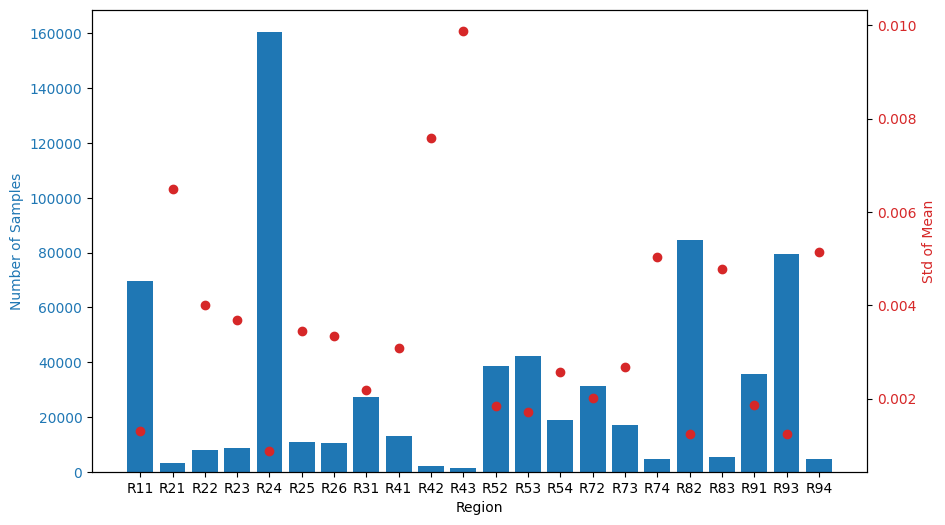

In [229]:
# Standard deviation of posterior samples of alpha for each region
alpha_std_region = stacked.std(dim="sample").alpha.to_dataframe().sort_index()
# Number of samples per region
samples_per_region = df.groupby("Region")["Exposure"].count()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel("Region")

color = "tab:blue"
ax1.bar(samples_per_region.index, samples_per_region.values, color=color)
ax1.set_ylabel("Number of Samples", color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.scatter(samples_per_region.index, alpha_std_region, color=color)
ax2.set_ylabel("Std of Mean", color=color)
ax2.tick_params(axis="y", labelcolor=color)

Here, we can see that regions with the most samples have the lowest standard deviations of their mean estimates, reflecting the fact that we are more confident about the precision of those estimates because of the large amount of data.

# Multilevel Varying Intercepts Alternative

In [7]:
region, regions = df["Region"].factorize()
obs = df.index

with pm.Model(coords={"regions": regions, "obs": obs}) as model:
    sigma_1 = pm.HalfNormal("sigma_1", 25)
    mu = pm.Normal("mu", 10)
    alpha = pm.Normal("alpha", mu, sigma_1, dims="regions")

    sigma_2 = pm.HalfNormal("sigma_2", 25)

    exposure = pm.Normal(
        "exposure", alpha[region], sigma_2, observed=df["Exposure"].values, dims="obs"
    )

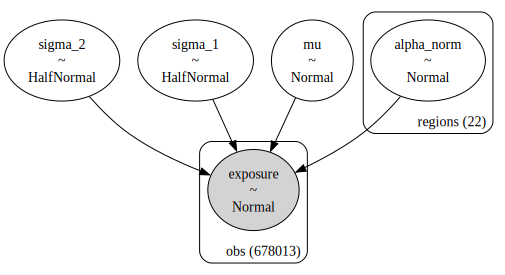

In [8]:
pm.model_to_graphviz(model)

In [9]:
with model:
    idata = pm.sample(draws=100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_1, mu, alpha_norm, sigma_2]


KeyError: 0